In [1]:
import numpy as np
import pandas as pd
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

from pyaw import utils
from pyaw.swarm import rotate_vector_by_quaternion

In [2]:
fps = ['./SW_OPER_MAGB_HR_1B_1349_20140219T020540_20140219T034014.pkl',
       './aux_SW_OPER_MAGB_HR_1B_1349_20140219T020540_20140219T034014.pkl',
       './IGRF_SW_OPER_MAGB_HR_1B_1349_20140219T020540_20140219T034014.pkl',
       './SW_EXPT_EFIB_TCT16_1349_20140219T020540_20140219T034014.pkl']

In [3]:
df_b = pd.read_pickle(fps[0])
df_b_aux = pd.read_pickle(fps[1])
df_b_IGRF = pd.read_pickle(fps[2])
df_e = pd.read_pickle(fps[3])

In [4]:
df_b_clip = df_b[['B_NEC', 'Longitude', 'Latitude', 'Radius','q_NEC_CRF']]
df_b_aux_clip = df_b_aux[['QDLat', 'QDLon', 'MLT']]
df_b_IGRF_clip = df_b_IGRF[['B_NEC_IGRF']]
df_e_clip = df_e[['Longitude', 'Latitude', 'Radius', 'VsatE', 'VsatN', 'Ehy', 'Ehx']]

In [5]:
st = '20140219T023100'
et = '20140219T024100'
df_b_clip = df_b_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_b_aux_clip = df_b_aux_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_b_IGRF_clip = df_b_IGRF_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_e_clip = df_e_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]

np.all(np.equal(df_b_clip.index.values,df_b_IGRF_clip.index.values))

True

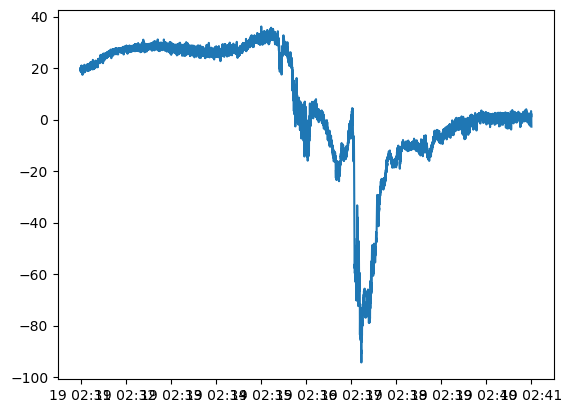

In [6]:
ehx = df_e_clip['Ehx'].values

plt.plot(df_e_clip.index.values, ehx)
plt.show()

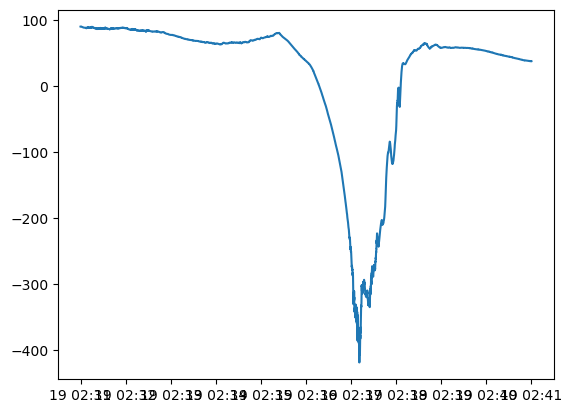

In [7]:
b_sc = []  # b in S/C
b_igrf_sc = []  # igrf b in S/C
for b_nec,b_nec_igrf,q_NEC_CRF in zip(df_b_clip['B_NEC'].values,df_b_IGRF_clip['B_NEC_IGRF'].values,df_b_clip['q_NEC_CRF'].values):
    q_CRF_NEC = np.array([-q_NEC_CRF[0],-q_NEC_CRF[1],-q_NEC_CRF[2],q_NEC_CRF[3]])
    b_sc.append(rotate_vector_by_quaternion(b_nec, q_CRF_NEC))
    b_igrf_sc.append(rotate_vector_by_quaternion(b_nec_igrf, q_CRF_NEC))
b_sc = np.array(b_sc)
b_igrf_sc = np.array(b_igrf_sc)

by1 = b_sc[:,1] - b_igrf_sc[:,1]

plt.plot(df_b_clip.index.values, by1)

In [8]:
datetimes_e = df_e_clip.index.values
datetimes_b = df_b_clip.index.values

by1 = utils.align_high2low(by1, datetimes_b, datetimes_e)

In [9]:
fs = 16
window = 'hann'
stft_window_seconds = 4  # second
nperseg = int(stft_window_seconds * fs)  # 每个窗的采样点数
noverlap = nperseg // 2  # 50%重叠

freqs, ts, Zxx_e = spectrogram(ehx, fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')
_, _, Zxx_b = spectrogram(by1, fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')

ts_dt64 = datetimes_e[0] + [np.timedelta64(int(_), 's') for _ in ts]

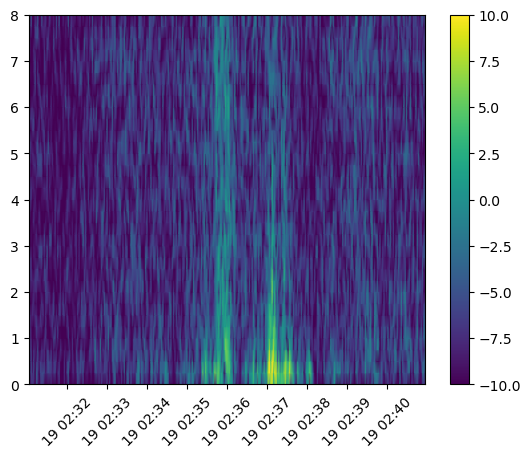

In [10]:
Zxx_e_m = np.abs(Zxx_e)
plt.pcolormesh(ts_dt64, freqs, 10*np.log10(Zxx_e_m), shading='gouraud',vmin=-10,vmax=10)  # 可以用初始值也可以用log10
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

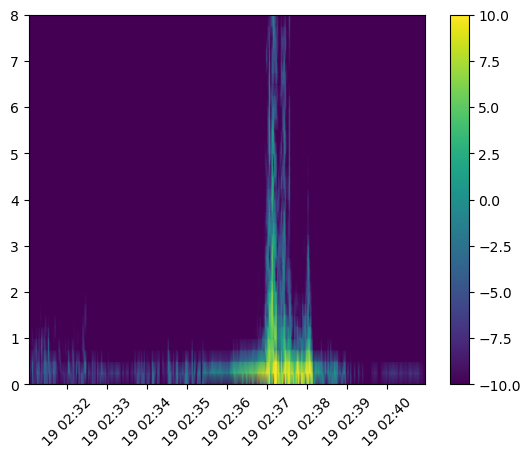

In [11]:
Zxx_b_m = np.abs(Zxx_b)
plt.pcolormesh(ts_dt64, freqs, 10*np.log10(Zxx_b_m), shading='gouraud',vmin=-10,vmax=10)
plt.colorbar()
plt.ylim([0, 8])
plt.xticks(rotation=45)
plt.show()

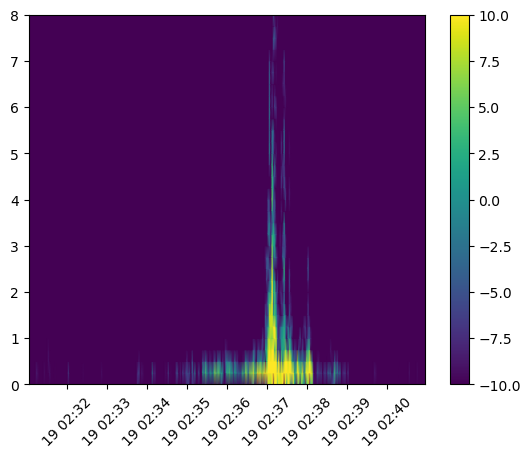

In [12]:
cross_e_b_spectral_density = Zxx_e * np.conj(Zxx_b)

cross_e_b_spectral_density_module = np.abs(cross_e_b_spectral_density)
plt.pcolormesh(ts_dt64, freqs, 10*np.log10(cross_e_b_spectral_density_module), shading='gouraud',vmin=-10,vmax=10)
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

In [13]:
coherences = utils.get_coherences(Zxx_e,Zxx_b,cross_e_b_spectral_density)

In [14]:
ts_dt64_split = utils.split_array(ts_dt64)

def get_middle_element(lst):
    n = len(lst)
    if n == 0:
        return None  # Handle the case of an empty list
    mid = n // 2
    if n % 2 == 0:  # Even number of elements
        return lst[mid - 1]  # Return the former one of the two middle elements
    else:  # Odd number of elements
        return lst[mid]  # Return the single middle element


dts_cohe = [get_middle_element(i) for i in ts_dt64_split]

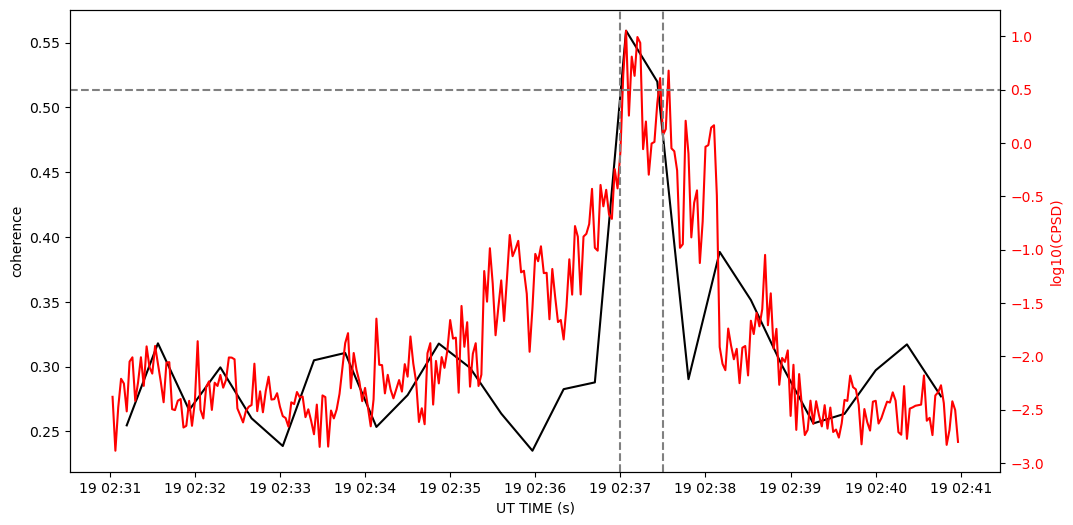

In [17]:
# Create a figure and the first axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first dataset
ax1.plot(dts_cohe, coherences, color='black', label='coherence')
ax1.set_xlabel('UT TIME (s)')
ax1.set_ylabel('coherence', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis with its own x-axis
ax2 = ax1.twinx()  # Share the same x-axis
ax2.plot(ts_dt64, np.log10(cross_e_b_spectral_density_module.mean(axis=0)), color='red', label='log10(CPSD)')
ax2.set_ylabel('log10(CPSD)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.axhline(0.5,color='gray',linestyle='--')

import matplotlib.dates as mdates

plt.axvline(mdates.date2num(np.datetime64('2014-02-19T02:37:00')),color='gray',linestyle='--')
plt.axvline(mdates.date2num(np.datetime64('2014-02-19T02:37:30')),color='gray',linestyle='--')
plt.xticks(rotation=45)
plt.show()